# Setup

In [1]:
import numpy as np
import pandas as pd
import pybaseball
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt


# Get batting data
The latest Lahman database can be downloaded directly from [here](https://github.com/chadwickbureau/baseballdatabank/archive/master.zip) or archived versions can be found [here](https://www.seanlahman.com/baseball-archive/statistics). Another option, which I will use here, is to use the [pybaseball](https://github.com/jldbc/pybaseball) package. It has a lot of useful tools that may come in handy later. 

Let's clean up the data a bit. We need the pitching data to remove pitchers since they are not typically strong batters. 

In [2]:
from pybaseball.lahman import batting
from pybaseball.lahman import pitching

# Get the data
batting_data = batting()
pitching_data = pitching()

# Add player's name
def add_name(ID):
    _player = _players.loc[_players.key_bbref.isin([ID]),:]
    if not _player.empty:
        try:
            fname = _player.name_first.item().capitalize()
            lname = _player.name_last.item().capitalize()
            name = fname + ' ' + lname
        except:
            print(_player)

    else:
        name = " "
    return  name

# Get names of players
_players = pybaseball.playerid_reverse_lookup(batting_data.playerID.tolist(),key_type='bbref')
_players.dropna(subset=["name_last","name_first"],axis=0,inplace=True)

# Remove unneeded columns
rows_to_keep = (~batting_data.playerID.isin(pitching_data.playerID)) & (batting_data.AB>0)
cols_to_keep = ["AB","H","playerID"]

# There are multiple rows for each player so group by player and get total H and AB
bd = batting_data.loc[rows_to_keep ,cols_to_keep].groupby(by="playerID",as_index=True).sum().reset_index()

# Add the player's name for ease of reading
bd["Name"] = bd.apply(lambda row: add_name(row.playerID),axis=1)

# Add batting average
bd["Avg"] = bd.H / bd.AB

# Check out the DF
bd.head(10)

,playerID,AB,H,Name,Avg
0,aaronha01,12364,3771,Hank Aaron,0.304998
1,aaronto01,944,216,Tommie Aaron,0.228814
2,abadan01,21,2,Andy Abad,0.095238
3,abadijo01,49,11,John Abadie,0.224490
4,abbated01,3044,772,Ed Abbaticchio,0.253614
5,abbotfr01,513,107,Fred Abbott,0.208577
6,abbotje01,596,157,Jeff Abbott,0.263423
7,abbotku01,2044,523,Kurt Abbott,0.255871
8,abbotod01,70,13,Ody Abbott,0.185714
9,abercda01,4,0,Frank Abercrombie,0.000000


Let's see what the data looks like.

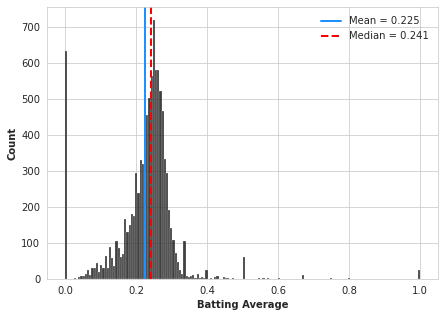

In [3]:
# Plot Batting avg for all players/all years
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    sns.histplot(data=bd,x="Avg",color='k',ax=ax)
    ax.axvline(x=bd.Avg.mean(),lw=2,color="dodgerblue",label="Mean = {}".format(round(bd.Avg.mean(),3)))
    ax.axvline(x=bd.Avg.median(),lw=2,linestyle='--',color='r',label="Median = {}".format(round(bd.Avg.median(),3)))
    ax.legend(frameon=False)
    ax.set_xlabel("Batting Average",fontweight="bold")
    ax.set_ylabel("Count",fontweight="bold")

Clearly there is something funky going on here. The data have a mean of 0.225 with a median of 0.240, however, we see that there is a scattering of data above ~.400 and a really high count with a 0.0 average. 

Let's see the players with the worst batting averages:

In [4]:
bd.sort_values(by="Avg").head(10)

,playerID,AB,H,Name,Avg
9398,westoal01,3,0,Al Weston,0.0
6822,payntge01,4,0,George Paynter,0.0
925,bradsda01,4,0,Dallas Bradshaw,0.0
6810,pattoto01,2,0,Tom Patton,0.0
6802,patteha03,1,0,Hank Patterson,0.0
3938,higby01,4,0,,0.0
9256,walshto01,1,0,Tom Walsh,0.0
2457,duggaji01,4,0,Jim Duggan,0.0
939,bramhar01,1,0,Art Bramhall,0.0
9255,walshjo04,8,0,Joe Walsh,0.0


Hmm... how about with the best batting averages...

In [5]:
bd.sort_values(by="Avg",ascending=False).head(10)

,playerID,AB,H,Name,Avg
9670,wrighal01,1,1,Al Wright,1.0
6985,pickuty01,1,1,Ty Pickup,1.0
9327,wattal01,1,1,Allie Watt,1.0
4856,kuczest01,1,1,Steve Kuczek,1.0
5130,lindsch02,1,1,Charlie Lindstrom,1.0
5297,lutzre01,1,1,Red Lutz,1.0
711,birasst01,2,2,Steve Biras,1.0
4083,hopkimi01,2,2,Mike Hopkins,1.0
6630,onisra01,1,1,Curly Onis,1.0
9699,yantzge01,1,1,George Yantz,1.0


Clearly this is not what we are looking for. Just for the heck of it, let's do the same thing but set a minimum number of ABs.

In [6]:
min_atbat = 500
bd.loc[bd.AB > min_atbat,:].sort_values(by="Avg",ascending=False).head(10)

,playerID,AB,H,Name,Avg
4089,hornsro01,8173,2930,Rogers Hornsby,0.358497
4275,jacksjo01,4981,1772,Shoeless joe Jackson,0.355752
2194,delahed01,7510,2597,Ed Delahanty,0.345806
3605,hamilbi01,6283,2164,Billy Hamilton,0.344421
3804,heilmha01,7787,2660,Harry Heilmann,0.341595
4578,keelewi01,8591,2932,Willie Keeler,0.341287
8794,terrybi01,6428,2193,Bill Terry,0.341164
3120,gehrilo01,8001,2721,Lou Gehrig,0.340082
3534,gwynnto01,9288,3141,Tony Gwynn,0.338178
4892,lajoina01,9590,3243,Nap Lajoie,0.338165


Now we start to see some names we recognize. Rogers Hornsby, Shoeless Joe, Billy Hamilton, Lou Gehrig, Tony Gwynn (I have his autographed ball!) all immediately stand out to me.

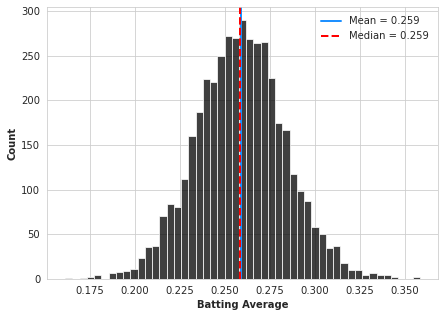

In [7]:
# Plot Batting avg for all players/all years
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    sns.histplot(data=bd.loc[bd.AB > min_atbat,:],x="Avg",color='k',ax=ax)
    ax.axvline(x=bd.loc[bd.AB > min_atbat,"Avg"].mean(),lw=2,color="dodgerblue",label="Mean = {}".format(round(bd.loc[bd.AB > min_atbat,"Avg"].mean(),3)))
    ax.axvline(x=bd.loc[bd.AB > min_atbat,"Avg"].median(),lw=2,linestyle='--',color='r',label="Median = {}".format(round(bd.loc[bd.AB > min_atbat,"Avg"].median(),3)))
    ax.legend(frameon=False)
    ax.set_xlabel("Batting Average",fontweight="bold")
    ax.set_ylabel("Count",fontweight="bold")

We want to fit the model X ~ Beta(alpha_0, beta_0).  My understanding is that we assume that the prior distribution is the beta distribution and the likelihood is a binomial. Our posterior distribution is a beta distribution. The prior and posterior predictive distributions are both beta-binomials ([useful explanation here](https://stats.stackexchange.com/questions/512148/beta-binomial-vs-updating-a-prior-beta-distribution?rq=1])). The key here is that instead of simply fitting a beta distribution based on the batting average, we also account for the total number of at-bats by including the binomial as the likelihood when estimating the parameters of the beta.

Unfortunately, unlike in `R` (shown in the book), we can't fit a beta-binomial directly in `python`. Here we adapt some [code from online](https://stackoverflow.com/questions/54505173/finding-alpha-and-beta-of-beta-binomial-distribution-with-scipy-optimize-and-log) to write out the probability density function of the beta-binomial and solve using maximum-likelihood estimation (`scipy.optimize.minimize`). 


In [8]:
# This solution adapated from: https://stackoverflow.com/questions/54505173/finding-alpha-and-beta-of-beta-binomial-distribution-with-scipy-optimize-and-log
def loglike_betabinom(params, *args):
    
    from scipy.special import gammaln

    a, b = params[0], params[1]
    k = args[0] # Hits
    n = args[1] # At-bats
    logpdf = gammaln(n+1) + gammaln(k+a) + gammaln(n-k+b) + gammaln(a+b) - \
     (gammaln(k+1) + gammaln(n-k+1) + gammaln(a) + gammaln(b) + gammaln(n+a+b))

    return -np.sum(logpdf) 

from scipy.optimize import minimize

init_params = [100, 250]
# note that I am putting 'H' in the args
result = minimize(loglike_betabinom, x0=init_params,
            args=(bd.loc[bd.AB > min_atbat,'H'], bd.loc[bd.AB > min_atbat,'AB']),
            method='L-BFGS-B', options={'disp': True, 'maxiter': 10000})
# print(result)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48739D+04    |proj g|=  3.27006D+02

At iterate    1    f=  2.34870D+04    |proj g|=  1.90334D+02

At iterate    2    f=  2.28361D+04    |proj g|=  1.55185D+01

At iterate    3    f=  2.28321D+04    |proj g|=  8.92397D-01

At iterate    4    f=  2.28321D+04    |proj g|=  1.05829D+00

At iterate    5    f=  2.28321D+04    |proj g|=  9.32413D-01

At iterate    6    f=  2.28321D+04    |proj g|=  7.35235D-01

At iterate    7    f=  2.28312D+04    |proj g|=  4.39831D-01


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    8    f=  2.28312D+04    |proj g|=  8.52742D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     23      1     0     0   8.527D-01   2.283D+04
  F =   22831.226246086961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


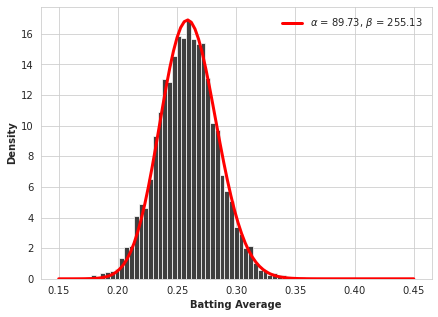

In [9]:
# Plot Batting avg for all players/all years
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    sns.histplot(data=bd.loc[bd.AB > 500,:],x="Avg",color='k',ax=ax,stat="density")
    # ax.axvline(x=bd.loc[bd.AB > 500,"Avg"].mean(),lw=2,color="dodgerblue",label="Mean = {}".format(round(bd.loc[bd.AB > 500,"Avg"].mean(),3)))
    # ax.axvline(x=bd.loc[bd.AB > 500,"Avg"].median(),lw=2,linestyle='--',color='r',label="Median = {}".format(round(bd.loc[bd.AB > 500,"Avg"].median(),3)))    
    x = np.linspace(.15,.45,100)
    ax.plot(x,stats.beta.pdf(x,result["x"][0],result["x"][1]),color='r',lw=3,label=r"$\alpha$ = {}, $\beta$ = {}".format(round(result["x"][0],2),round(result["x"][1],2)))
    ax.legend(frameon=False)
    ax.set_xlabel("Batting Average",fontweight="bold")
    ax.set_ylabel("Density",fontweight="bold")
    # ax.plot

Now that we know the parameters of the beta distribution, we can use them to make estimate of batting average for any new player's data. The example in the book compares a batter with 4/10 (H/AB) to 300/100 (H/AB). Let's try it here.

In [10]:
alpha0, beta0 = result["x"][0],result["x"][1]
_4_of_10 = (4 + alpha0) / (10 + alpha0 + beta0)
_300_of_1000 = (300 + alpha0) / (1000 + alpha0 + beta0)

pd.DataFrame({"Batting Average (EB Estimate)": [_4_of_10, _300_of_1000]},index=["4/10","300/100"])

,Batting Average (EB Estimate)
4/10,0.264138
300/100,0.289794


Clearly our estimate tells us that the batter with 300/1000 is a better batter than 4/10. Intuitively, this makes sense since we have a lot more evidence to support this. We can write a simple function to apply this to our dataframe.

In [11]:
def eb_estimate(alpha0,beta0,H,AB):
    return (H+alpha0) / (AB + alpha0 + beta0)

In [12]:
bd["eb estimate Avg"] = bd.apply(lambda row: eb_estimate(alpha0,beta0,row.H,row.AB),axis=1)
bd

,playerID,AB,H,Name,Avg,eb estimate Avg
0,aaronha01,12364,3771,Hank Aaron,0.304998,0.303783
1,aaronto01,944,216,Tommie Aaron,0.228814,0.237211
2,abadan01,21,2,Andy Abad,0.095238,0.250730
3,abadijo01,49,11,John Abadie,0.224490,0.255756
4,abbated01,3044,772,Ed Abbaticchio,0.253614,0.254284
...,...,...,...,...,...,...
9797,zuninmi01,2226,446,Mike Zunino,0.200359,0.208386
9798,zupcibo01,795,199,Bob Zupcic,0.250314,0.253305
9799,zupofr01,18,3,Frank Zupo,0.166667,0.255559
9800,zuvelpa01,491,109,Paul Zuvella,0.221996,0.237758


Now lets check out the batters with the highest EB Estimate.

In [13]:
bd.sort_values(by="eb estimate Avg",ascending=False).head(10)

,playerID,AB,H,Name,Avg,eb estimate Avg
4089,hornsro01,8173,2930,Rogers Hornsby,0.358497,0.354518
4275,jacksjo01,4981,1772,Shoeless joe Jackson,0.355752,0.349565
2194,delahed01,7510,2597,Ed Delahanty,0.345806,0.342047
3605,hamilbi01,6283,2164,Billy Hamilton,0.344421,0.340039
4578,keelewi01,8591,2932,Willie Keeler,0.341287,0.338158
3804,heilmha01,7787,2660,Harry Heilmann,0.341595,0.338143
8794,terrybi01,6428,2193,Bill Terry,0.341164,0.337041
3120,gehrilo01,8001,2721,Lou Gehrig,0.340082,0.336782
4892,lajoina01,9590,3243,Nap Lajoie,0.338165,0.335458
3534,gwynnto01,9288,3141,Tony Gwynn,0.338178,0.335387


... and the worst ...

In [14]:
bd.sort_values(by="eb estimate Avg",ascending=True).head(10)

,playerID,AB,H,Name,Avg,eb estimate Avg
630,bergebi01,3028,516,Bill Bergen,0.170410,0.179590
6709,oylerra01,1265,221,Ray Oyler,0.174704,0.193018
2521,eastehe01,1129,203,Henry Easterday,0.179805,0.198616
9187,vukovjo01,559,90,John Vukovich,0.161002,0.198850
4185,humphjo01,364,52,John Humphries,0.142857,0.199944
352,bakerge01,474,74,George Baker,0.156118,0.199952
3227,gladmbu01,380,56,Buck Gladmon,0.147368,0.201049
7727,ryanmi02,1920,370,Mike Ryan,0.192708,0.202985
249,armbrch01,355,53,Charlie Armbruster,0.149296,0.203944
8947,traffbi01,663,116,Bill Traffley,0.174962,0.204128


# Figure 3.3 
A comparison between raw batting average (H/AB) and emperical Bayes estimate for all batters

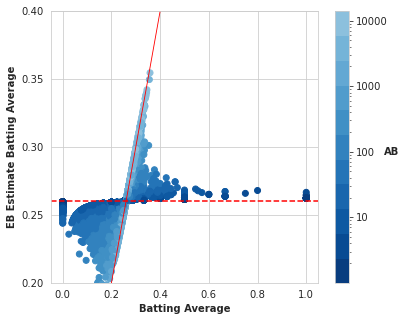

In [15]:
import matplotlib as mpl

with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot()
    # Get colormap
    cmap = mpl.cm.Blues_r(np.linspace(0,1,20))
    cmap = mpl.colors.ListedColormap(cmap[1:12])
    # Plot scatter 
    splot = ax.scatter(bd["Avg"],bd["eb estimate Avg"],c=bd["AB"],cmap=cmap,norm=mpl.colors.LogNorm())
    # Plot x=y
    ax.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),color='r',lw=0.85)
    # Plot pure eb estimate
    ax.axhline(y=(alpha0/(alpha0+beta0)),color='r',linestyle='--')
    # Clean up
    cbar_ticks = [0,10,100,1000,10000]
    cbar = plt.colorbar(splot,ticks=cbar_ticks)
    cbar.ax.set_yticklabels(list(map(str, cbar_ticks)))
    cbar.set_label("AB",rotation=0,fontweight="bold")
    ax.set_ylim(0.2,0.4)
    ax.set_yticks([0.2,0.25,0.3,0.35,0.4])
    ax.set_xlabel("Batting Average",fontweight="bold")
    ax.set_ylabel("EB Estimate Batting Average",fontweight="bold")

# Save the data for later

In [20]:
# Save dataframe
bd.to_pickle("./data/batting_data_ch3.pkl")

# Save beta parameters
with open("./data/eb_estimate_beta_params.npy","wb") as f:
    np.save(f,[alpha0, beta0])